In [ ]:
import numpy as np
from netCDF4 import Dataset

# Open the source file
with Dataset('classified_temperature_groups_1980_2014.nc', 'r') as src:
    # Assume the temperature variable is the only 2D float variable or named 'temperature'
    # Adjust this if your variable has a different name
    for varname in src.variables:
        if src.variables[varname].ndim >= 2 and src.variables[varname].dtype.kind in 'f':
            temp_data = src.variables[varname][:]
            break
    x = src.variables['x'][:]
    y = src.variables['y'][:]

# Create the new file
with Dataset('mean_temperature_coldest_month.nc', 'w', format='NETCDF4') as dst:
    # Dimensions
    dst.createDimension('x', len(x))
    dst.createDimension('y', len(y))
    # Variables
    x_var = dst.createVariable('x', 'f4', ('x',))
    y_var = dst.createVariable('y', 'f4', ('y',))
    avgtemp = dst.createVariable('AvgTemp', 'f4', ('y', 'x'), fill_value=np.nan, zlib=True, complevel=5)
    # Assign data
    x_var[:] = x
    y_var[:] = y
    avgtemp[:, :] = temp_data
    # Attributes
    avgtemp.long_name = "Average temperature of coldest month in 1980 -2014 (Daymet)"
    avgtemp.units = "C"
    # Add projection info as global attributes
    dst.short_lambert_conformal_conic = ""
    dst.grid_mapping_name = "lambert_conformal_conic"
    dst.longitude_of_central_meridian = -100.
    dst.latitude_of_projection_origin = 42.5
    dst.false_easting = 0.
    dst.false_northing = 0.
    dst.standard_parallel = "25., 60."
    dst.semi_major_axis = 6378137.
    dst.inverse_flattening = 298.257223563

print("Saved as mean_temperature_coldest_month.nc")

Saved as mean_tempearture_coldest_month.nc


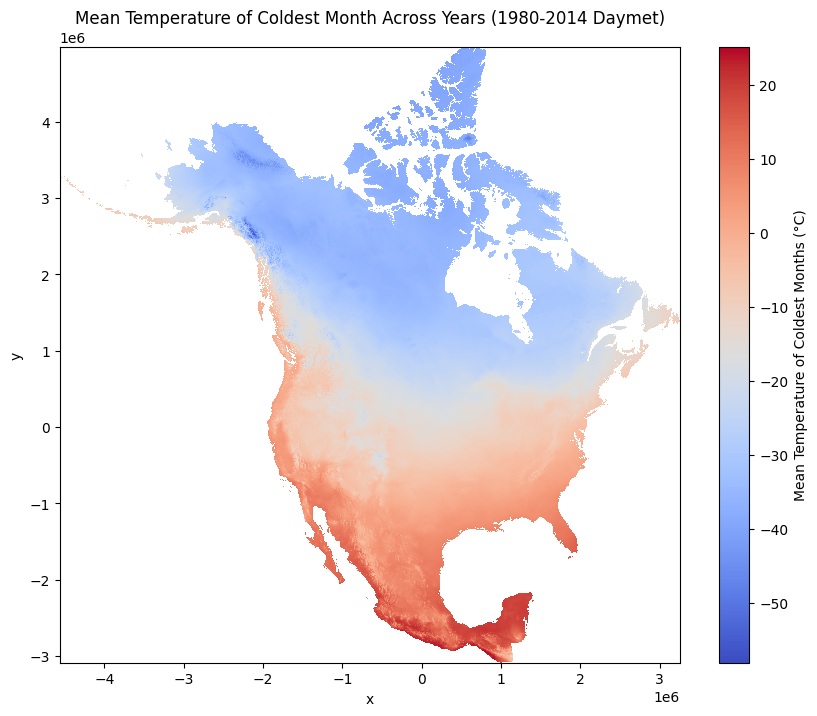

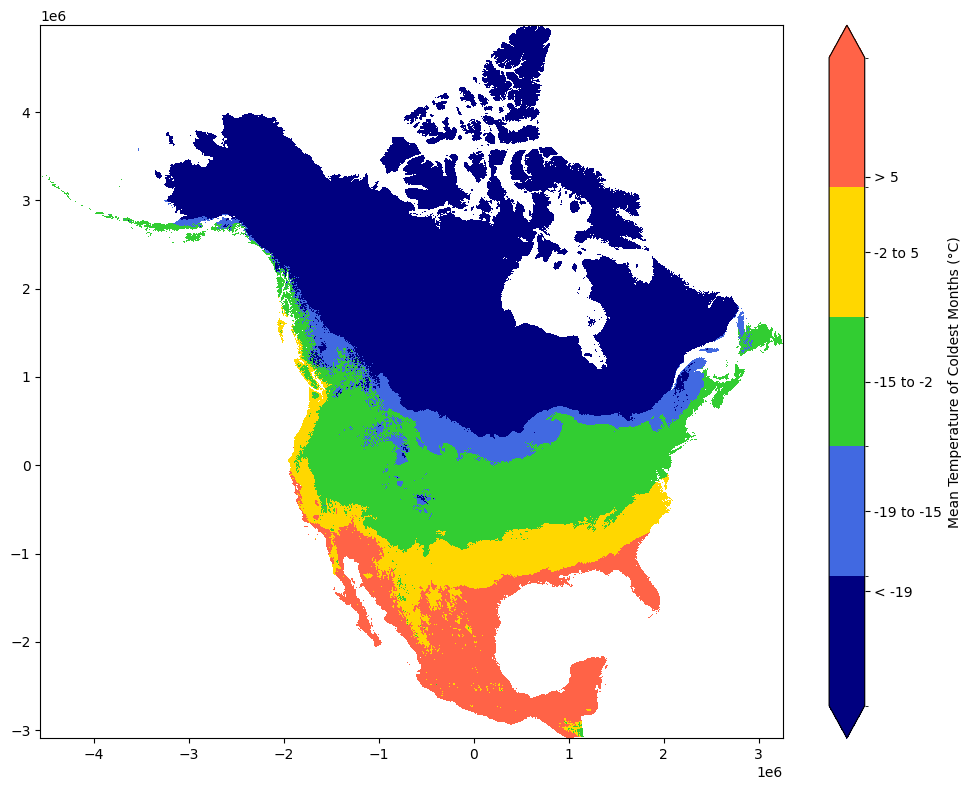

In [ ]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Open the NetCDF file
filename = "mean_temperature_coldest_month.nc"
ds = nc.Dataset(filename)

# Read variables
x = ds.variables['x'][:]
y = ds.variables['y'][:]
lowest_temp = ds.variables['AvgTemp'][:]

# Mask NaN values if present
lowest_temp = np.ma.masked_invalid(lowest_temp)

plt.figure(figsize=(10, 8))
plt.pcolormesh(x, y, lowest_temp, shading='auto', cmap='coolwarm')
plt.colorbar(label='Mean Temperature of Coldest Months (°C)')
plt.title('Mean Temperature of Coldest Month Across Years (1980-2014 Daymet)')
plt.xlabel('x')
plt.ylabel('y')

# Add contour lines at -19, -15, -2, 5
#contour_levels = [-19, -15, -2, 5]
#X, Y = np.meshgrid(x, y)
#contours = plt.contour(X, Y, lowest_temp, levels=contour_levels, colors='k', linewidths=1.2)
#plt.clabel(contours, fmt='%d', colors='k')

# Define boundaries and colors for the regions
bounds = [-70, -19, -15, -2, 5, 30]
colors = ['navy', 'royalblue', 'limegreen', 'gold', 'tomato']
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(10, 8))
mesh = plt.pcolormesh(x, y, lowest_temp, shading='auto', cmap=cmap, norm=norm)
cbar = plt.colorbar(mesh, boundaries=bounds, ticks=[-25, -17, -8.5, 1.5, 7], extend='both')
cbar.ax.set_yticklabels(['< -19', '-19 to -15', '-15 to -2', '-2 to 5', '> 5'])
cbar.set_label('Mean Temperature of Coldest Months (°C)')


plt.tight_layout()
plt.show()

ds.close()

In [47]:
import numpy as np
from netCDF4 import Dataset
import rasterio

# Read AvgTemp from NetCDF
with Dataset('mean_temperature_coldest_month.nc') as nc:
    avgtemp = nc.variables['AvgTemp'][:]

# Read the mask from the GeoTIFF
with rasterio.open('large_daymet_mask.tif') as src:
    mask_data = src.read(1)
    out_shape = mask_data.shape

# Prepare an output array (same shape as mask, fill with np.nan)
mapped_temp = np.full(out_shape, np.nan, dtype=avgtemp.dtype)

# Place avgtemp into mapped_temp with the given offset
row_offset, col_offset = 101, 98
rows, cols = avgtemp.shape

mapped_temp[row_offset:row_offset+rows, col_offset:col_offset+cols] = avgtemp

# Now mapped_temp has AvgTemp in the correct location, rest is np.nan
# Example: Save as a new GeoTIFF (optional)
with rasterio.open(
    'mapped_avgtemp.tif', 'w',
    driver='GTiff',
    height=out_shape[0], width=out_shape[1],
        count=1, dtype=mapped_temp.dtype,
        crs=src.crs, transform=src.transform
) as dst:
    dst.write(mapped_temp, 1)

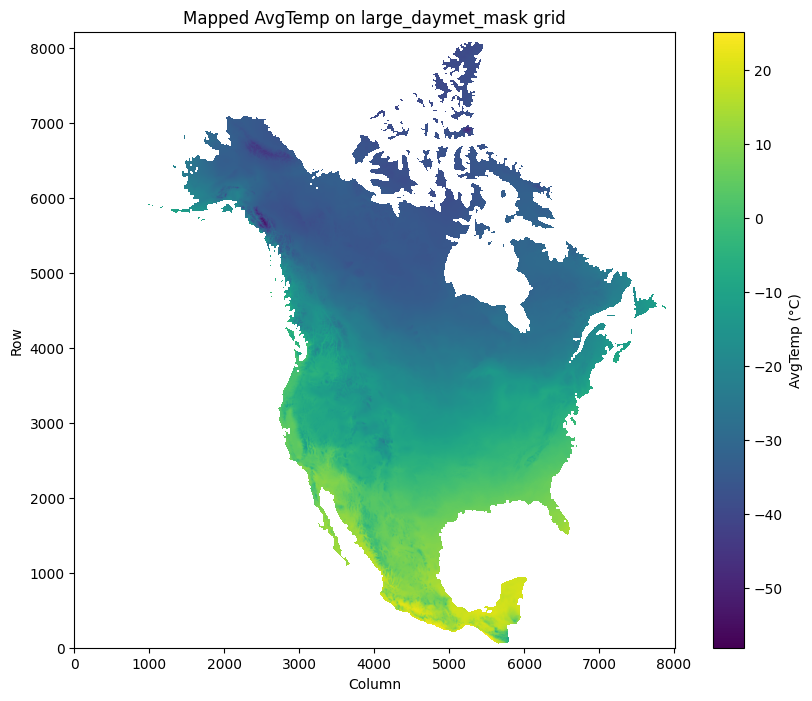

In [65]:
plt.figure(figsize=(10, 8))
plt.imshow(mapped_temp, origin='lower')
plt.title('Mapped AvgTemp on large_daymet_mask grid')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='AvgTemp (°C)')
plt.show()

In [56]:
import numpy as np
from netCDF4 import Dataset
import rasterio

# Read AvgTemp from NetCDF
with Dataset('mean_temperature_coldest_month.nc') as nc:
    avgtemp = nc.variables['AvgTemp'][:]

# Read the mask from the GeoTIFF
with rasterio.open('large_daymet_mask.tif') as src:
    mask_data = src.read(1)
    out_shape = mask_data.shape

# Prepare an output array (same shape as mask, fill with np.nan)
mapped_temp = np.full(out_shape, np.nan, dtype=avgtemp.dtype)

# Place avgtemp into mapped_temp with the given offset
row_offset, col_offset = 101, 98
rows, cols = avgtemp.shape
nrows = out_shape[0]

# Adjusted row offset for flipping
adjusted_row_offset = nrows - row_offset - rows

mapped_temp[adjusted_row_offset:adjusted_row_offset+rows, col_offset:col_offset+cols] = avgtemp

# Flip vertically before writing to GeoTIFF
mapped_temp_flipped = np.flipud(mapped_temp)

with rasterio.open(
    'mapped_avgtemp.tif', 'w',
    driver='GTiff',
    height=out_shape[0], width=out_shape[1],
    count=1, dtype=mapped_temp.dtype,
    crs=src.crs, transform=src.transform
) as dst:
    dst.write(mapped_temp_flipped, 1)

In [52]:
with rasterio.open('large_daymet_mask.tif') as src:
    mask_data = src.read(1)  # Read first band
    shape = mask_data.shape
    print("Shape of large_daymet_mask.tif:", shape)

    # Find all rows that have at least one mask==1
    rows_with_1 = np.where(np.any(mask_data == 1, axis=1))[0]
    if len(rows_with_1) > 0:
        top_row = rows_with_1[0]
        print("Top row with mask=1:", top_row)
    else:
        print("No row has mask=1")

Shape of large_daymet_mask.tif: (8220, 8011)
Top row with mask=1: 101


In [64]:

# Function to rewrite a NetCDF file with compression
def rewrite_with_compression(input_file, output_file):
    with Dataset(input_file, 'r') as src:
        # Create a new NetCDF file with compression
        with Dataset(output_file, 'w', format='NETCDF4') as dst:
            # Copy dimensions
            for name, dimension in src.dimensions.items():
                dst.createDimension(name, (len(dimension) if not dimension.isunlimited() else None))
            
            # Copy variables with compression
            for name, variable in src.variables.items():
                var_out = dst.createVariable(name, variable.datatype, variable.dimensions, zlib=True, complevel=5)
                var_out.setncatts({k: variable.getncattr(k) for k in variable.ncattrs()})
                var_out[:] = variable[:]
    
    print(f"Rewritten {input_file} to {output_file} with compression.")         

# Rewrite the NetCDF file with compression
rewrite_with_compression('tight_na_mask.nc', 'tight_na_mask_compressed.nc')
rewrite_with_compression('daymet_na_mask.nc', 'daymet_na_mask_compressed.nc')

# Open the compressed NetCDF file to verify

Rewritten tight_na_mask.nc to tight_na_mask_compressed.nc with compression.
Rewritten daymet_na_mask.nc to daymet_na_mask_compressed.nc with compression.


In [ ]:
#open the tight_na_mask.tif file and add the aligned_temp_nalcms_masked into it and save the result as a new tif file
import rasterio
from rasterio.transform import from_origin    

#undo_shift = 22
undo_shift = 22  # Adjust this value based on your alignment needs

if undo_shift > 0:
    aligned_temp_nalcms_masked_unshifted = np.vstack([
        aligned_temp_nalcms_masked[undo_shift:, :],
        np.full((undo_shift, aligned_temp_nalcms_masked.shape[1]), np.nan, dtype=aligned_temp_nalcms_masked.dtype)
    ])
else:
    aligned_temp_nalcms_masked_unshifted = aligned_temp_nalcms_masked.copy()

# Open the tight_na_mask.tif file to get its profile
with rasterio.open('tight_na_mask.tif') as src:
    profile = src.profile       
    profile.update(dtype='float32', count=1, nodata=np.nan)
    # Do NOT change height/width/transform if shape matches!
    # If aligned_temp_nalcms_masked.shape == src.shape, just use the original profile:
    with rasterio.open('avgtemp_nalcms_masked.tif', 'w', **profile) as dst:
        dst.write(aligned_temp_nalcms_masked_unshifted.astype('float32'), 1)  
print("Saved aligned temperature data as avgtemp_nalcms_masked.tif")  


Saved aligned temperature data as avgtemp_nalcms_masked.tif


In [ ]:
import numpy as np
from netCDF4 import Dataset

# Read tight_na_mask.nc and aligned_temp_nalcms_masked
with Dataset('tight_na_mask.nc', 'r') as src_mask:
    mask_data = src_mask.variables['na_mask'][:]
    y = src_mask.dimensions['y'].size
    x = src_mask.dimensions['x'].size
    # If you have attributes or coordinates, copy as needed

# Assume aligned_temp_nalcms_masked is already in memory, otherwise load from file
# aligned_temp_nalcms_masked = np.load('aligned_temp_nalcms_masked.npy')  # Example if saved as .npy

# Write new NetCDF with both mask and temperature (with compression)

    
with Dataset('AvgTemp_nalcms_mask.nc', 'w', format='NETCDF4') as dst:
    # Create dimensions
    dst.createDimension('y', y)
    dst.createDimension('x', x)
    # Copy mask variable
    mask_var = dst.createVariable('na_mask', 'i1', ('y', 'x'), zlib=True, complevel=5)
    mask_var[:, :] = mask_data
    mask_var.long_name = "tight_na_mask"
    # Add temperature variable
    temp_var = dst.createVariable('AvgTemp', 'f4', ('y', 'x'), fill_value=np.nan, zlib=True, complevel=5)
    temp_var[:, :] = aligned_temp_nalcms_masked
    temp_var.long_name = "Average temperature of coldest month (aligned to tight_na_mask)"
    temp_var.units = "C"
print("Saved as AvgTemp_nalcms_mask.nc")

Saved as AvgTemp_nalcms_mask.nc


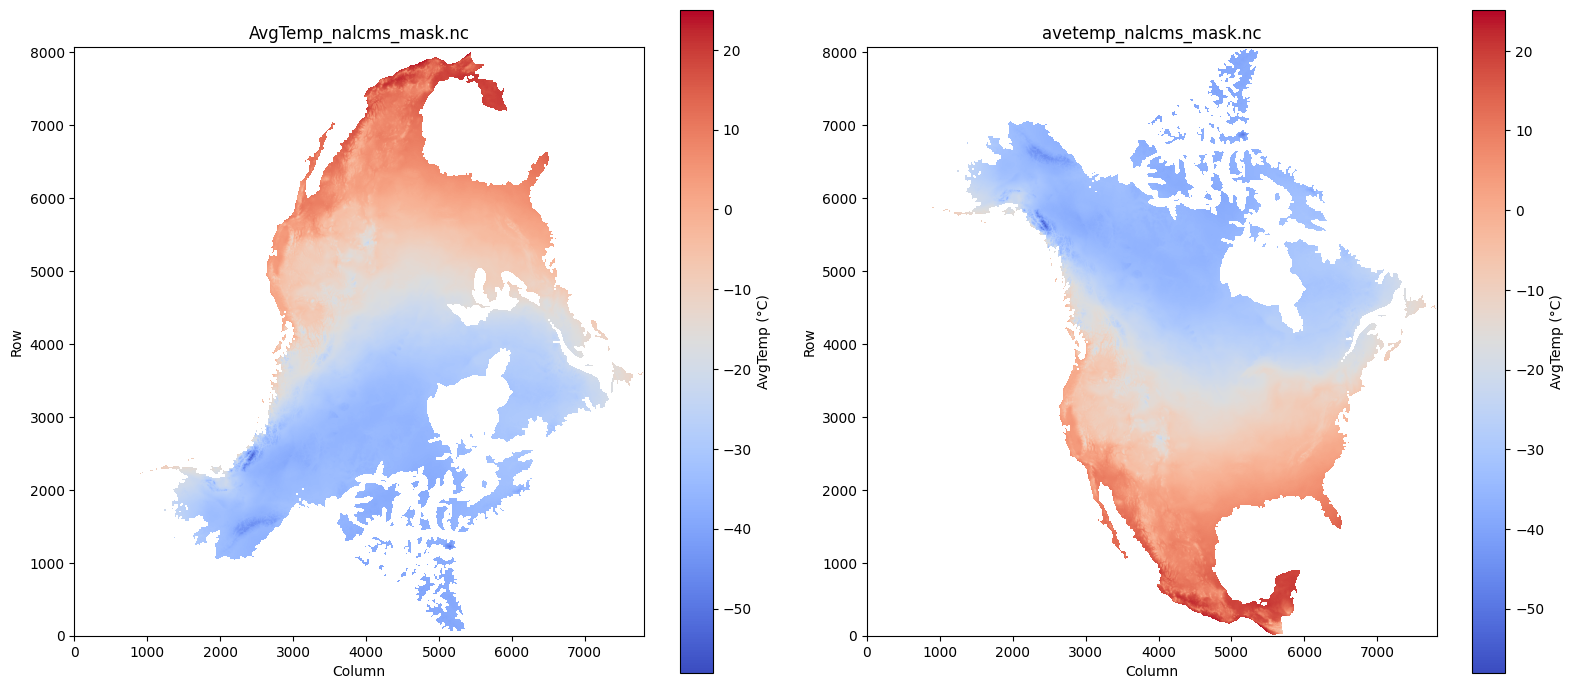

In [12]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt

# Read both NetCDF files
with Dataset('AvgTemp_nalcms_mask.nc') as nc1, Dataset('avetemp_nalcms_mask.nc') as nc2:
    avgtemp1 = nc1.variables['AvgTemp'][:]
    avgtemp2 = nc2.variables['AvgTemp'][:]

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.imshow(avgtemp1, origin='lower', cmap='coolwarm')
plt.title('AvgTemp_nalcms_mask.nc')
plt.colorbar(label='AvgTemp (°C)')
plt.xlabel('Column')
plt.ylabel('Row')

plt.subplot(1, 2, 2)
plt.imshow(avgtemp2, origin='lower', cmap='coolwarm')
plt.title('avetemp_nalcms_mask.nc')
plt.colorbar(label='AvgTemp (°C)')
plt.xlabel('Column')
plt.ylabel('Row')

plt.tight_layout()
plt.show()

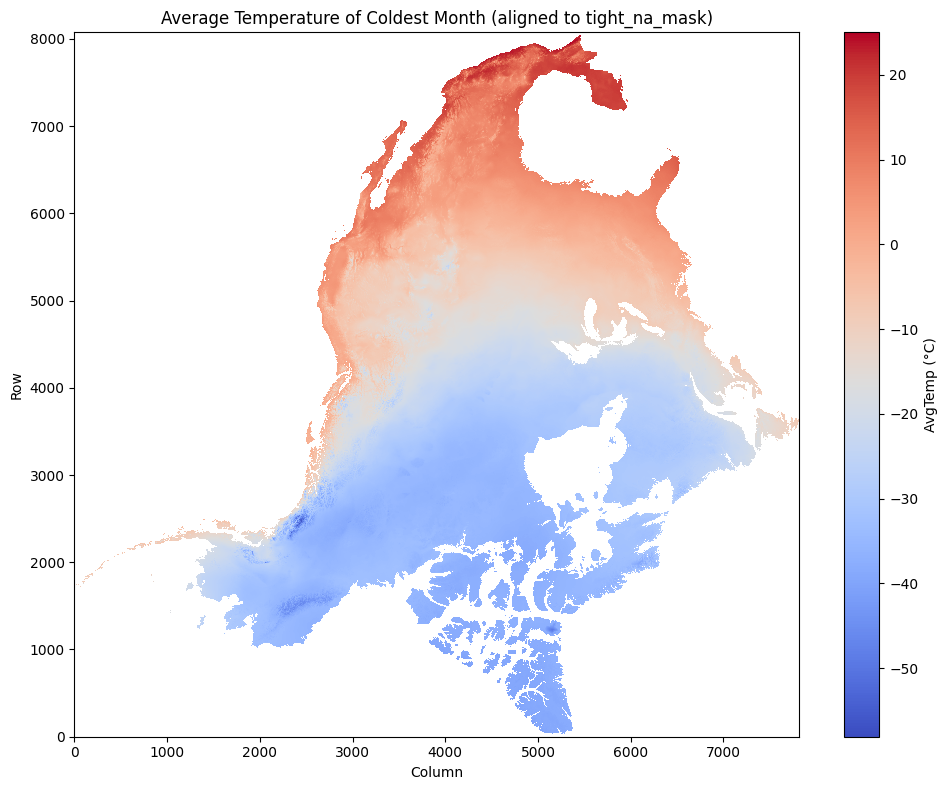

In [10]:
# Open the NetCDF file
with Dataset('AvgTemp_nalcms_mask.nc') as nc:
    avgtemp = nc.variables['AvgTemp'][:]

plt.figure(figsize=(10, 8))
plt.pcolormesh(avgtemp, cmap='coolwarm')
plt.colorbar(label='AvgTemp (°C)')
plt.title('Average Temperature of Coldest Month (aligned to tight_na_mask)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()



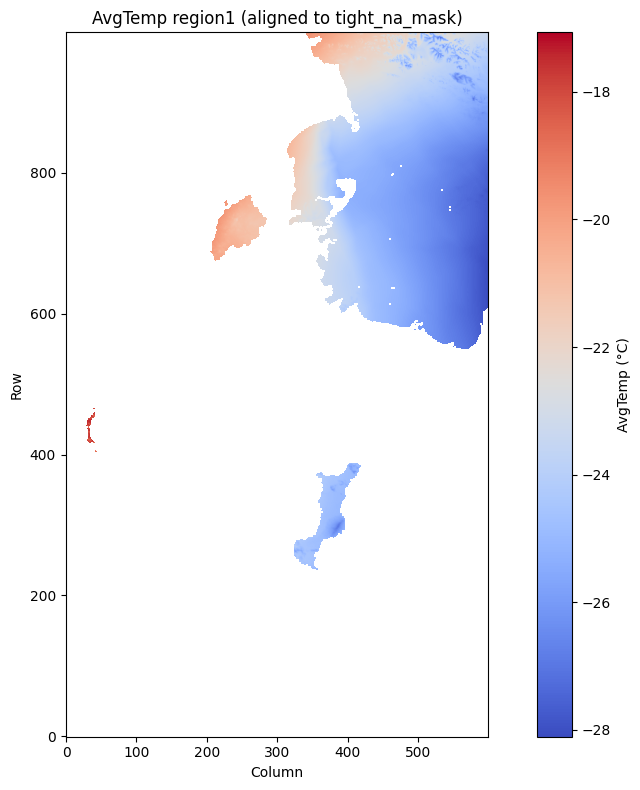

In [11]:
region1 = avgtemp[1000:2000, 1000:1600]

#plot the region1
plt.figure(figsize=(10, 8))
plt.imshow(region1, origin='lower', cmap='coolwarm')
plt.colorbar(label='AvgTemp (°C)')
plt.title('AvgTemp region1 (aligned to tight_na_mask)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()




In [ ]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt

# Open the NetCDF file
with Dataset('landtype1_nalcms_Temperate_needleleaf_in_daymet.nc') as nc:
    count = nc.variables['landtype_count'][:]

# use count to create a mask, where count is not nan
mask = np.where(np.isnan(count), 0, 1)

# create another mask with AvgTemp where data is not nan
with Dataset('AvgTemp_nalcms_mask.nc') as nc:
    avgtemp = nc.variables['AvgTemp'][:]
    temp_mask = np.where(np.isnan(avgtemp), 0, 1)

# temp_mask is a cropped mask of the mask from landtype1_nalcms_Temperate_needleleaf_in_daymet.nc,
# find the bounding box of temp_mask in the mask from landtype1_nalcms_Temperate_needleleaf_in_daymet.nc

      



with Dataset('landtype1_nalcms_Temperate_needleleaf_in_daymet.nc') as nc:
    landtype_mask = nc.variables['landtype_mask'][:].astype(int)
# Create a mask where landtype_count is greater than 0
mask = np.where(landtype_mask > 0, 1, 0)
# Create a mask where AvgTemp is not NaN
# temp_mask is a cropped mask of mask, so we need to align it with the mask
# we need find the bounding box of the temp_mask in the mask
# Find the bounding box of temp_mask in mask
y_indices, x_indices = np.where(temp_mask == 1)
if y_indices.size > 0 and x_indices.size > 0:
    min_y, max_y = np.min(y_indices), np.max(y_indices)
    min_x, max_x = np.min(x_indices), np.max(x_indices)
    # Crop the mask to the bounding box of temp_mask
    mask_cropped = mask[min_y:max_y + 1, min_x:max_x + 1]
    temp_mask_aligned = temp_mask[min_y:max_y + 1, min_x:max_x + 1]
else:
    print("No valid data found in temp_mask, cannot align with mask.")
    temp_mask_aligned = None
# Check if temp_mask_aligned is not None before proceeding

if temp_mask_aligned is not None:
    # compare the shapes of mask_cropped and temp_mask
    print("Shape of mask_cropped:", mask_cropped.shape)
    print("Shape of temp_mask:", temp_mask.shape)
    # create difference mask
    diff_mask = np.zeros_like(mask_cropped, dtype=np.int8)
    diff_mask[(mask_cropped == 1) & (temp_mask == 1)] = 0  # in both mask
    diff_mask[(mask_cropped == 1) & (temp_mask != 1)] = 1  # in mask only       
    diff_mask[(temp_mask == 1) & (mask_cropped != 1)] = 2  # in temp_mask only
    # Print summary of the difference mask
    unique, counts = np.unique(diff_mask, return_counts=True)       
    for v, c in zip(unique, counts):
        if v == 0:
            print(f"Value: {v}, Count: {c}  (common )")
        elif v == 1:
            print(f"Value: {v}, Count: {c} (in mask not in temp_mask)")
        elif v == 2:
            print(f"Value: {v}, Count: {c} (in temp_mask not in mask)")


    # Plot the original mask and the aligned temp_mask
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(mask, origin='lower', cmap='gray')
    plt.title('Original Mask (landtype1_nalcms)')
    plt.colorbar(label='Mask Value')

    plt.subplot(1, 2, 2)
    plt.imshow(temp_mask_aligned, origin='lower', cmap='gray')
    plt.title('Aligned Temp Mask (AvgTemp_nalcms_mask)')
    plt.colorbar(label='Mask Value')

    plt.tight_layout()
    plt.show()


Shape of mask_cropped: (8021, 7814)
Shape of temp_mask: (8075, 7814)


ValueError: operands could not be broadcast together with shapes (8021,7814) (8075,7814) 

Large mask bounding box: min_y=101, max_y=8121, min_x=98, max_x=7911
Temp mask bounding box: min_y=29, max_y=8049, min_x=0, max_x=7813
Offset for alignment: (min_y=-72, min_x=-98)
Unique values in aligned_large_mask: [0 1]
Unique values in temp_mask: [0 1]
Best row shift for alignment: -29 (positive means shift mask2 down)
New shape of aligned_large_mask after applying best shift: (8075, 7814)


/Users/7xw/Library/Python/3.9/lib/python/site-packages/numpy/_core/numeric.py:362: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Unique values in diff_mask: [-1  0  1]
Value: 0, Count: 21130388  (common )
Value: 1, Count: 126814 (in large mask not in temp_mask)


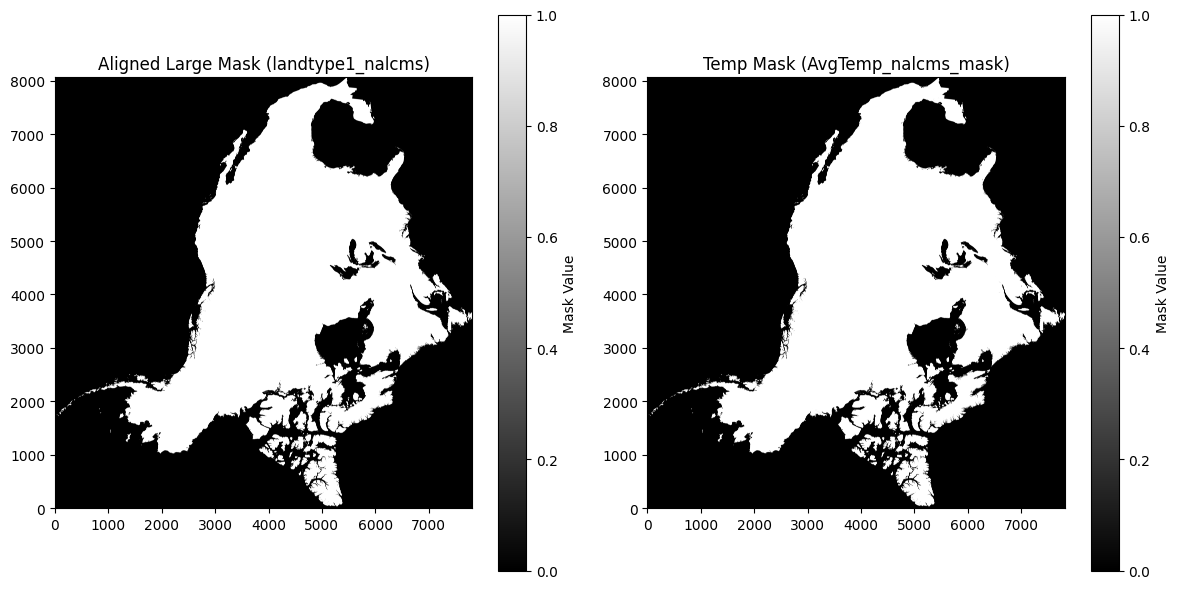

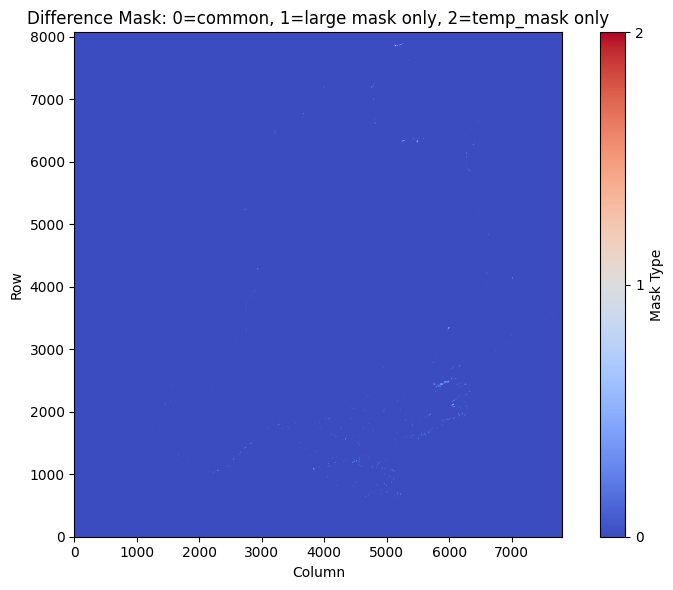

In [ ]:
large_mask = mask  # Use the mask as the large mask

# Find bounding box in large mask
large_y, large_x = np.where(large_mask == 1)
large_min_y, large_min_x = np.min(large_y), np.min(large_x)

# Find bounding box in temp_mask
temp_y, temp_x = np.where(temp_mask == 1)
temp_min_y, temp_min_x = np.min(temp_y), np.min(temp_x)

# Print the bounding boxes
print(f"Large mask bounding box: min_y={large_min_y}, max_y={np.max(large_y)}, min_x={large_min_x}, max_x={np.max(large_x)}")
print(f"Temp mask bounding box: min_y={temp_min_y}, max_y={np.max(temp_y)}, min_x={temp_min_x}, max_x={np.max(temp_x)}")
# Calculate the offset to align temp_mask within large_mask
print(f"Offset for alignment: (min_y={temp_min_y - large_min_y}, min_x={temp_min_x - large_min_x})")

# Now we can align temp_mask within large_mask
offset_y = temp_min_y - large_min_y
offset_x = temp_min_x - large_min_x
# Create a crop the large mask with the same shape as temp_mask
aligned_large_mask = large_mask[large_min_y:large_min_y + temp_mask.shape[0], large_min_x:large_min_x + temp_mask.shape[1]]

# what is the unique values in aligned_large_mask and temp_mask
unique_large_mask = np.unique(aligned_large_mask)
unique_temp_mask = np.unique(temp_mask)
print("Unique values in aligned_large_mask:", unique_large_mask)
print("Unique values in temp_mask:", unique_temp_mask)


# Fill masked values with 0 for comparison
mask1_filled = np.ma.filled(temp_mask, 0)
mask2_filled = np.ma.filled(aligned_large_mask, 0)

# Find optimal row shift to maximize overlap
max_overlap = -1
best_shift = 0
search_range = 50  # Try shifts from -50 to +50 rows

for shift in range(-search_range, search_range + 1):
    if shift < 0:
        m1 = mask1_filled[-shift:, :]
        m2 = mask2_filled[:shift, :]
    elif shift > 0:
        m1 = mask1_filled[:-shift, :]
        m2 = mask2_filled[shift:, :]
    else:
        m1 = mask1_filled
        m2 = mask2_filled
    overlap = np.sum((m1 == 1) & (m2 == 1))
    if overlap > max_overlap:
        max_overlap = overlap
        best_shift = shift

print(f"Best row shift for alignment: {best_shift} (positive means shift mask2 down)")
# Apply the shift to aligned_large_mask
if best_shift < 0:
    aligned_large_mask = np.vstack([
        np.full((-best_shift, aligned_large_mask.shape[1]), np.nan, dtype=aligned_large_mask.dtype),
        aligned_large_mask[:best_shift, :]
    ])
elif best_shift > 0:
    aligned_large_mask = np.vstack([
        aligned_large_mask[best_shift:, :],
        np.full((best_shift, aligned_large_mask.shape[1]), np.nan, dtype=aligned_large_mask.dtype)
    ])
# Print the new shape of aligned_large_mask
print("New shape of aligned_large_mask after applying best shift:", aligned_large_mask.shape)

# create a difference mask between aligned_large_mask and temp_mask
diff_mask = np.zeros_like(aligned_large_mask, dtype=np.int8) -1 
diff_mask[(aligned_large_mask == 1) & (temp_mask == 1)] = 0  # in both mask
diff_mask[(aligned_large_mask == 1) & (temp_mask != 1)] = 1  # in large mask only           
diff_mask[(temp_mask == 1) & (aligned_large_mask != 1)] = 2  # in temp_mask only

# Print unique values and counts for diff_mask
unique_diff_mask = np.unique(diff_mask)
print("Unique values in diff_mask:", unique_diff_mask)

# Print summary of the difference mask
unique, counts = np.unique(diff_mask, return_counts=True) 
for v, c in zip(unique, counts):
    if v == 0:
        print(f"Value: {v}, Count: {c}  (common )")
    elif v == 1:
        print(f"Value: {v}, Count: {c} (in large mask not in temp_mask)")
    elif v == 2:
        print(f"Value: {v}, Count: {c} (in temp_mask not in large mask)")

# Plot the aligned large mask and the temp_mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(aligned_large_mask, origin='lower', cmap='gray')
plt.title('Aligned Large Mask (landtype1_nalcms)')
plt.colorbar(label='Mask Value')
plt.subplot(1, 2, 2)        
plt.imshow(temp_mask, origin='lower', cmap='gray')
plt.title('Temp Mask (AvgTemp_nalcms_mask)')
plt.colorbar(label='Mask Value')
plt.tight_layout()
plt.show()
# Plot the difference mask
plt.figure(figsize=(8, 6))
plt.imshow(diff_mask==1, origin='lower', cmap='coolwarm', vmin=0, vmax=2)
plt.title('Difference Mask: 0=common, 1=large mask only, 2=temp_mask only')
plt.colorbar(ticks=[0, 1, 2], label='Mask Type')
plt.xlabel('Column')            
plt.ylabel('Row')
plt.tight_layout()
plt.show()




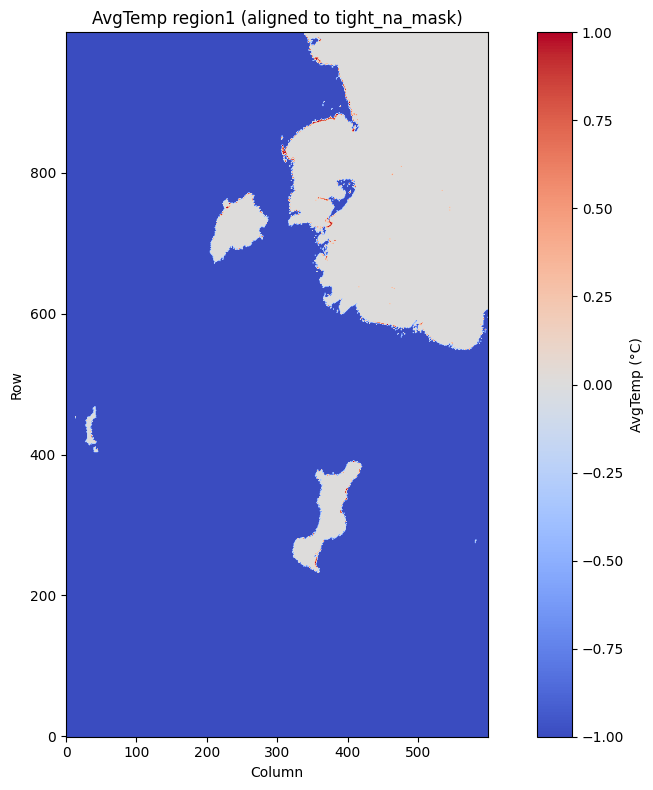

In [33]:
region1 = diff_mask[1000:2000, 1000:1600]

#plot the region1
plt.figure(figsize=(10, 8))
plt.imshow(region1, origin='lower', cmap='coolwarm')
plt.colorbar(label='AvgTemp (°C)')
plt.title('AvgTemp region1 (aligned to tight_na_mask)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()

In [34]:
# Find bounding box in large mask
large_y, large_x = np.where(aligned_large_mask == 1)
large_min_y, large_min_x = np.min(large_y), np.min(large_x)

# Find bounding box in temp_mask
temp_y, temp_x = np.where(temp_mask == 1)
temp_min_y, temp_min_x = np.min(temp_y), np.min(temp_x)

# Print the bounding boxes
print(f"Aligned large mask bounding box: min_y={large_min_y}, max_y={np.max(large_y)}, min_x={large_min_x}, max_x={np.max(large_x)}")
print(f"Temp mask bounding box: min_y={temp_min_y}, max_y={np.max(temp_y)}, min_x={temp_min_x}, max_x={np.max(temp_x)}")
# Calculate the offset to align temp_mask within large_mask
print(f"Offset for alignment: (min_y={temp_min_y - large_min_y}, min_x={temp_min_x - large_min_x})")

Aligned large mask bounding box: min_y=29, max_y=8049, min_x=0, max_x=7813
Temp mask bounding box: min_y=29, max_y=8049, min_x=0, max_x=7813
Offset for alignment: (min_y=0, min_x=0)


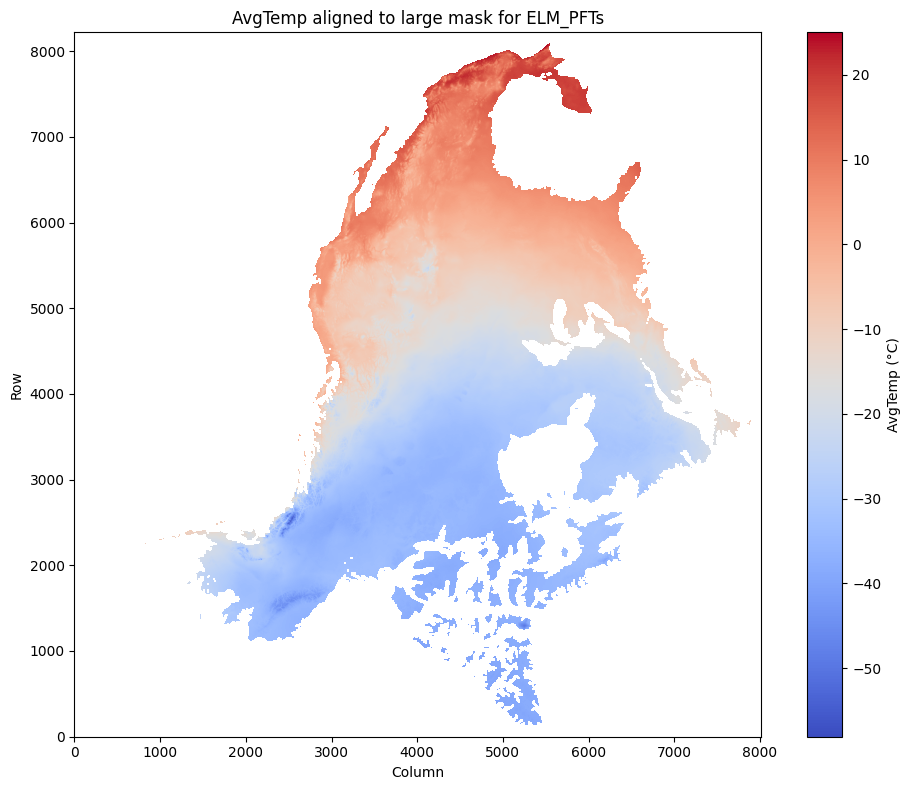

Saved as aligned_temp_to_large_nalcms_mask.nc


In [61]:
import numpy as np
from netCDF4 import Dataset

# Load large mask (landtype1_nalcms_Temperate_needleleaf_in_daymet.nc)
with Dataset('landtype1_nalcms_Temperate_needleleaf_in_daymet.nc') as nc:
    count = nc.variables['landtype_count'][:]
    large_mask = np.where(np.isnan(count), 0, 1)

# Load temp_mask (from AvgTemp_nalcms_mask.nc or similar)
with Dataset('AvgTemp_nalcms_mask.nc') as nc:
    temp_data = nc.variables['AvgTemp'][:]
    temp_mask = np.where(~np.isnan(temp_data), 1, 0)

# Find bounding box of temp_mask
temp_y, temp_x = np.where(temp_mask == 1)
temp_min_y, temp_max_y = np.min(temp_y), np.max(temp_y)
temp_min_x, temp_max_x = np.min(temp_x), np.max(temp_x)

# Find bounding box of large_mask
large_y, large_x = np.where(large_mask == 1)
large_min_y, large_min_x = np.min(large_y), np.min(large_x)

# Calculate offset to align temp_mask in large_mask
offset_y = temp_min_y - large_min_y
offset_x = temp_min_x - large_min_x

# Optionally, apply row shift if needed (e.g., from previous alignment)

col_shift = 98  # Set this if you have a known shift

# Prepare output array (same shape as large_mask, fill with np.nan)
output = np.full(large_mask.shape, np.nan, dtype=temp_data.dtype)

# Place temp_data into output at the correct location
start_y = temp_min_y - offset_y + row_shift
start_x = temp_min_x - offset_x
end_y = start_y + temp_data.shape[0]
end_x = start_x + temp_data.shape[1]

output[start_y:end_y, start_x:end_x] = temp_data

# we need to shift the output to align with the large_mask
row_shift = 29  # Set this if you have a known shift
if row_shift < 0:
    output = np.vstack([
        np.full((-row_shift, output.shape[1]), np.nan, dtype=output.dtype),
        output[:row_shift, :]
    ])
elif row_shift > 0:
    output = np.vstack([
        output[row_shift:, :],
        np.full((row_shift, output.shape[1]), np.nan, dtype=output.dtype)
    ])          

# Plot the output to verify alignment
plt.figure(figsize=(10, 8)) 
plt.imshow(output, origin='lower', cmap='coolwarm')
plt.colorbar(label='AvgTemp (°C)')
plt.title('AvgTemp aligned to large mask for ELM_PFTs')
plt.xlabel('Column')    
plt.ylabel('Row')
plt.tight_layout()
plt.show()


# Save to NetCDF with the same shape as large_mask
with Dataset('aligned_temp_to_large_nalcms_mask.nc', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', large_mask.shape[0])
    dst.createDimension('x', large_mask.shape[1])
    temp_var = dst.createVariable('AvgTemp', 'f4', ('y', 'x'), fill_value=np.nan, zlib=True, complevel=5)
    temp_var[:, :] = output
    temp_var.long_name = "AvgTemp aligned to large mask for ELM_PFTs"
    temp_var.units = "C"
print("Saved as aligned_temp_to_large_nalcms_mask.nc")

Unique values in diff_mask: [-1  0  1]
Value: 0, Count: 21130388  (common )
Value: 1, Count: 126814 (in large mask not in temp_mask)


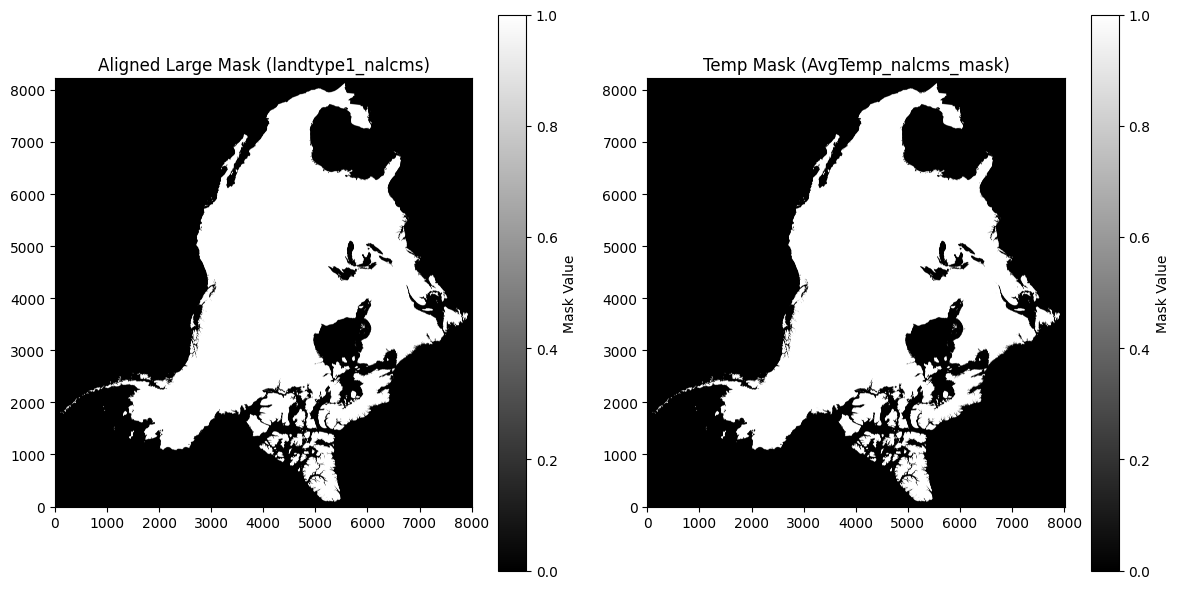

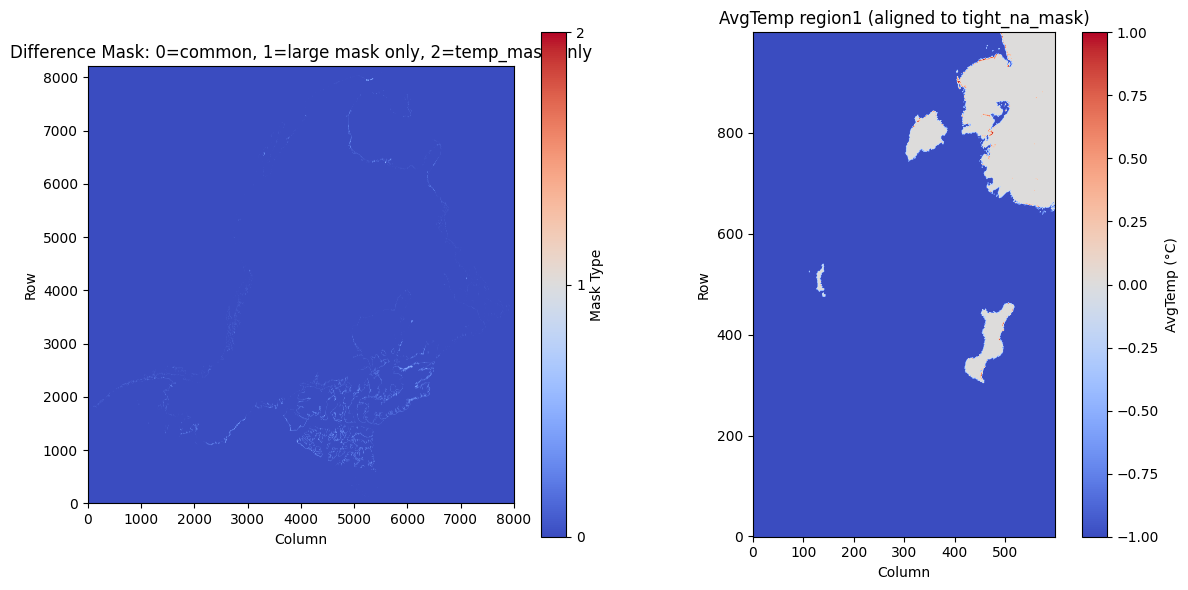

In [62]:
#create masks from the aligned_temp_to_large_nalcms_mask.nc and landtype1_nalcms_Temperate_needleleaf_in_daymet.nc
import numpy as np
from netCDF4 import Dataset
# Load the aligned temperature data     
with Dataset('aligned_temp_to_large_nalcms_mask.nc') as nc:
    aligned_temp = nc.variables['AvgTemp'][:]
    temp_mask = np.where(~np.isnan(aligned_temp), 1, 0)

# Load the large mask (landtype1_nalcms_Temperate_needleleaf_in_daymet.nc)
with Dataset('landtype1_nalcms_Temperate_needleleaf_in_daymet.nc') as nc:
    count = nc.variables['landtype_count'][:]
    large_mask = np.where(np.isnan(count), 0, 1)
    
# create a difference mask between aligned_large_mask and temp_mask
diff_mask = np.zeros_like(large_mask, dtype=np.int8) -1 
diff_mask[(large_mask == 1) & (temp_mask == 1)] = 0  # in both mask
diff_mask[(large_mask == 1) & (temp_mask != 1)] = 1  # in large mask only           
diff_mask[(temp_mask == 1) & (large_mask != 1)] = 2  # in temp_mask only

# Print unique values and counts for diff_mask
unique_diff_mask = np.unique(diff_mask)
print("Unique values in diff_mask:", unique_diff_mask)

# Print summary of the difference mask
unique, counts = np.unique(diff_mask, return_counts=True) 
for v, c in zip(unique, counts):
    if v == 0:
        print(f"Value: {v}, Count: {c}  (common )")
    elif v == 1:
        print(f"Value: {v}, Count: {c} (in large mask not in temp_mask)")
    elif v == 2:
        print(f"Value: {v}, Count: {c} (in temp_mask not in large mask)")

# Plot the aligned large mask and the temp_mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(large_mask, origin='lower', cmap='gray')
plt.title('Aligned Large Mask (landtype1_nalcms)')
plt.colorbar(label='Mask Value')
plt.subplot(1, 2, 2)        
plt.imshow(temp_mask, origin='lower', cmap='gray')
plt.title('Temp Mask (AvgTemp_nalcms_mask)')
plt.colorbar(label='Mask Value')
plt.tight_layout()
plt.show()


# Plot the difference mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(diff_mask==1, origin='lower', cmap='coolwarm', vmin=0, vmax=2)
plt.title('Difference Mask: 0=common, 1=large mask only, 2=temp_mask only')
plt.colorbar(ticks=[0, 1, 2], label='Mask Type')
plt.xlabel('Column')            
plt.ylabel('Row')


region1 = diff_mask[1000:2000, 1000:1600]
plt.subplot(1, 2, 2)
plt.imshow(region1, origin='lower', cmap='coolwarm')
plt.colorbar(label='AvgTemp (°C)')
plt.title('AvgTemp region1 (aligned to tight_na_mask)')
plt.xlabel('Column')
plt.ylabel('Row')




plt.tight_layout()
plt.show()

In [79]:
#create pft1-2 from the aligned_temp_to_large_nalcms_mask.nc and landtype1_nalcms_Temperate_needleleaf_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype1_nalcms_Temperate_needleleaf_in_daymet.nc'
elm_pft = 'pft1-2'  # Define the PFT name for this landtype

# Load the averaged temperature data     
with Dataset('aligned_temp_to_large_nalcms_mask.nc') as nc:
    avg_temp = nc.variables['AvgTemp'][:]

# Load the large mask (landtype1_nalcms_Temperate_needleleaf_in_daymet.nc)
with Dataset('landtype1_nalcms_Temperate_needleleaf_in_daymet.nc') as nc:
    count = nc.variables['landtype_count'][:]

upper_bound = -2  # Define the upper bound for PFT2
lower_bound = -19 # Define the lower bound for PFT1

# Only consider cells with count >= 0 and valid temperature
valid = (~np.isnan(avg_temp)) & (count >= 0)

# Initialize output arrays
pft1 = np.zeros_like(count, dtype=int)
pft2 = np.zeros_like(count, dtype=int)

# Masks for each region
mask1 = valid & (avg_temp <= lower_bound)
mask2 = valid & (avg_temp > upper_bound)
mask_between = valid & (avg_temp > lower_bound) & (avg_temp <= upper_bound)

# Assign values
pft2[mask1] = count[mask1]
pft1[mask2] = count[mask2]
# For the in-between region, use vectorized calculation
frac = (avg_temp[mask_between] - lower_bound) / (upper_bound - lower_bound)
pft1[mask_between] = (count[mask_between] * frac).astype(int)
pft2[mask_between] = count[mask_between] - pft2[mask_between]

# save the pft1 and pft2 as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft1.shape[0])
    dst.createDimension('x', pft1.shape[1])
    pft1_var = dst.createVariable('pft1_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft1_var[:, :] = pft1
    pft1_var.long_name = "PFT 1 count based on AvgTemp"
    pft1_var.units = "count"
    pft2_var = dst.createVariable('pft2_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft2_var[:, :] = pft2
    pft2_var.long_name = "PFT 2 count based on AvgTemp"
    pft2_var.units = "count"
    avg_temp_var = dst.createVariable('AvgTemp', 'f4', ('y', 'x'), fill_value=np.nan, zlib=True, complevel=5)
    avg_temp_var[:, :] = avg_temp
    avg_temp_var.long_name = "Average temperature of coldest month (aligned to large mask)"
    avg_temp_var.units = "C"    
    # add a global attribute for the temperature bounds
    dst.setncattr('temperature_bounds', f'PFT 2: <= {lower_bound} C, PFT 1: > {upper_bound} C')
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")


/Users/7xw/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:489: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)


Saved PFT counts as pft1-2_landtype1_nalcms_Temperate_needleleaf_in_daymet.nc


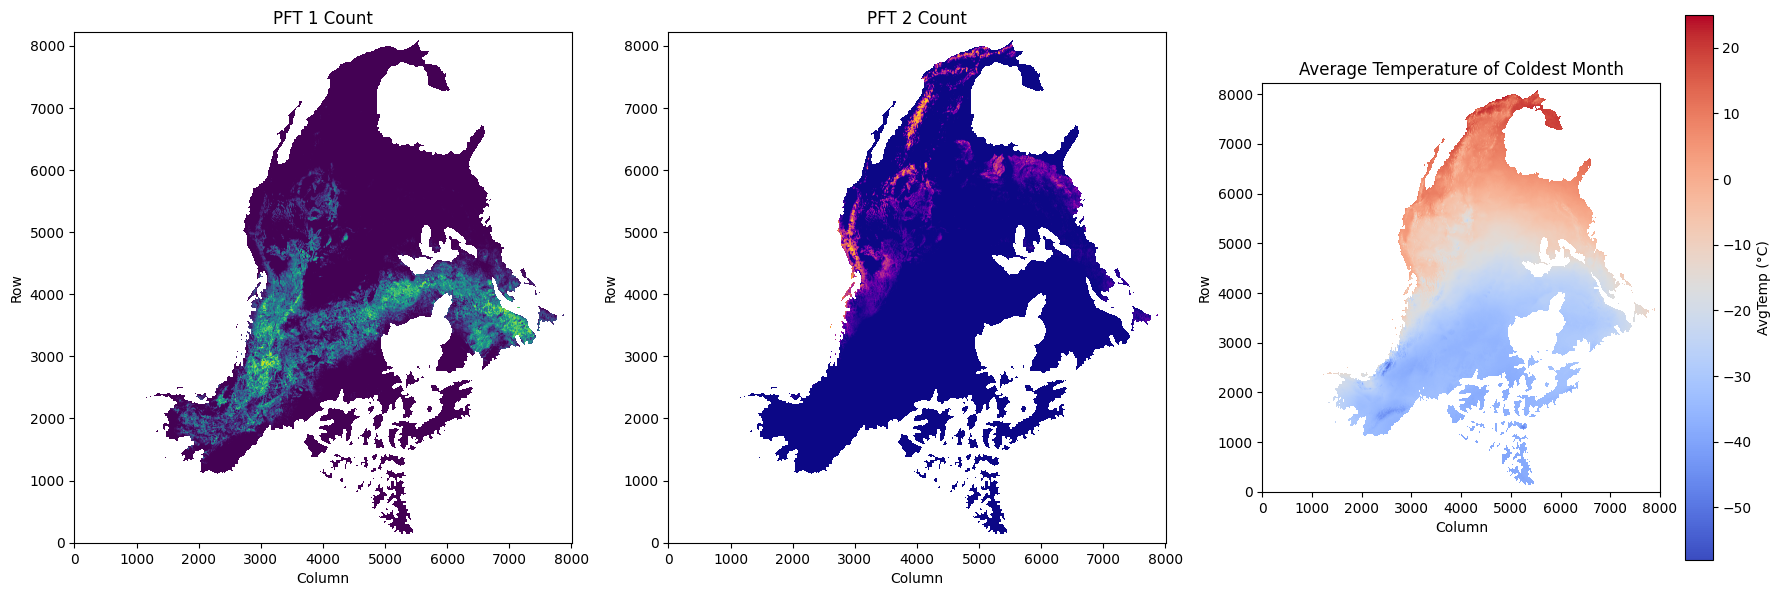

In [65]:
#plot the pft1 and pft2 and the avg_temp
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt     
# Load the PFT counts and average temperature
with Dataset('pft1-2_landtype1_nalcms_Temperate_needleleaf.nc') as nc:
    pft1 = nc.variables['pft1_count'][:]
    pft2 = nc.variables['pft2_count'][:]
    avg_temp = nc.variables['AvgTemp'][:]
# Create a figure with subplots 
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# Plot PFT 1
axs[0].imshow(pft1, origin='lower', cmap='viridis')     
axs[0].set_title('PFT 1 Count')
axs[0].set_xlabel('Column')
axs[0].set_ylabel('Row')
# Plot PFT 2
axs[1].imshow(pft2, origin='lower', cmap='plasma')
axs[1].set_title('PFT 2 Count')
axs[1].set_xlabel('Column')     
axs[1].set_ylabel('Row')
# Plot Average Temperature
im = axs[2].imshow(avg_temp, origin='lower', cmap='coolwarm')
axs[2].set_title('Average Temperature of Coldest Month')
axs[2].set_xlabel('Column')
axs[2].set_ylabel('Row')
# Add colorbar for the average temperature plot
cbar = fig.colorbar(im, ax=axs[2], orientation='vertical')
cbar.set_label('AvgTemp (°C)')
plt.tight_layout()
plt.show()


Region 1 PFT 1 Count - Min: 0 Max: 340
Region 1 PFT 2 Count - Min: 0 Max: 0
Region 1 AvgTemp - Min: -26.999249 Max: -17.06422


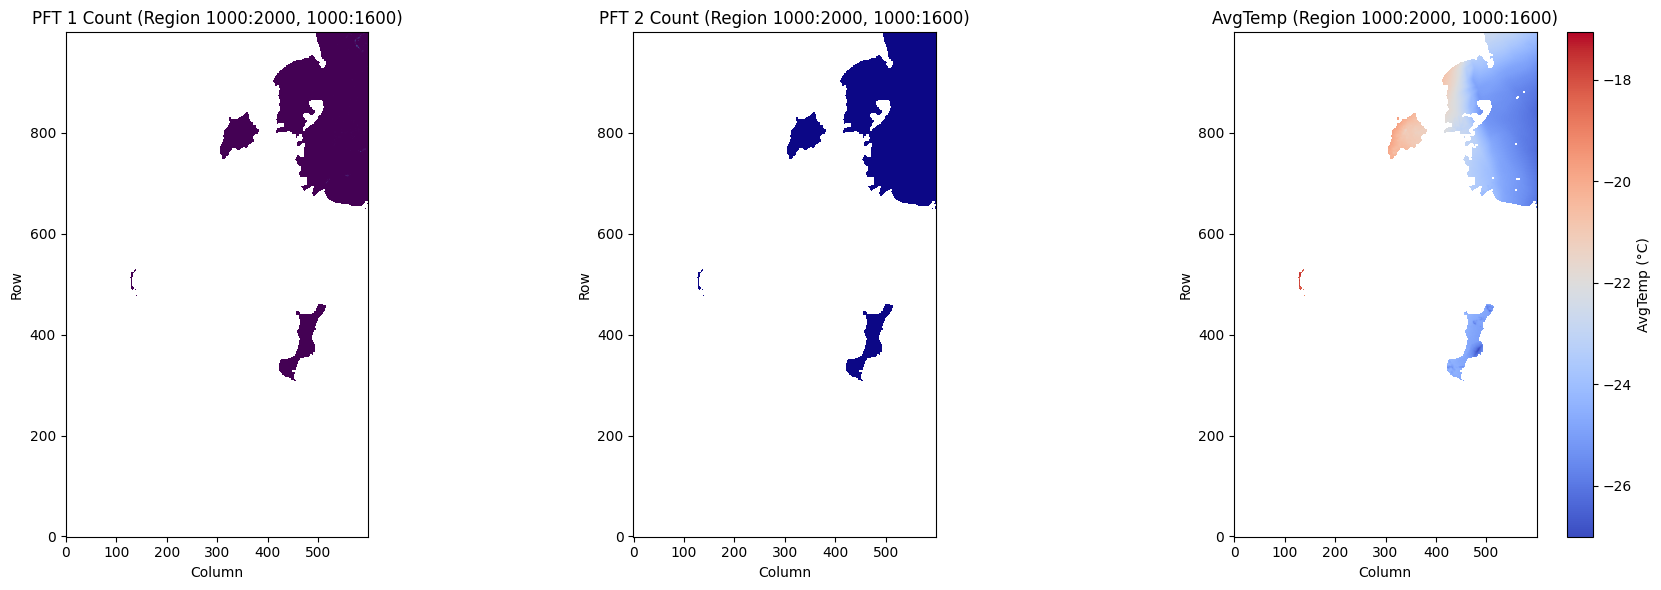

In [68]:
# plot a small region1 [1000:2000, 1000:1600] of the pft1 and pft2 and the avg_temp
region1_pft1 = pft1[1000:2000, 1000:1600]
region1_pft2 = pft2[1000:2000, 1000:1600]
region1_avg_temp = avg_temp[1000:2000, 1000:1600]

# print the max and min values of the region1_pft1, region1_pft2 and region1_avg_temp
print("Region 1 PFT 1 Count - Min:", np.min(region1_pft1), "Max:", np.max(region1_pft1))
print("Region 1 PFT 2 Count - Min:", np.min(region1_pft2), "Max:", np.max(region1_pft2))
print("Region 1 AvgTemp - Min:", np.nanmin(region1_avg_temp), "Max:", np.nanmax(region1_avg_temp))

# Plot the small region1 of pft1, pft2 and avg_temp
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(region1_pft1, origin='lower', cmap='viridis')            
plt.title('PFT 1 Count (Region 1000:2000, 1000:1600)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.subplot(1, 3, 2)
plt.imshow(region1_pft2, origin='lower', cmap='plasma')
plt.title('PFT 2 Count (Region 1000:2000, 1000:1600)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.subplot(1, 3, 3)
plt.imshow(region1_avg_temp, origin='lower', cmap='coolwarm')       
plt.title('AvgTemp (Region 1000:2000, 1000:1600)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='AvgTemp (°C)')
plt.tight_layout()


In [118]:
#create pft2 from the aligned_temp_to_large_nalcms_mask.nc and landtype2_nalcms_Taiga_needleleaf_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

# Load the large mask (landtype2_nalcms_Taiga_needleleaf_in_daymet.nc)
with Dataset('../landtypes_count/landtype2_nalcms_Taiga_needleleaf_in_daymet.nc') as nc:
    count = nc.variables['landtype_count'][:]

# print the max and min and mean values of the count
print("Count - Min:", np.min(count), "Max:", np.max(count), "Mean:", np.mean(count))

# assign all the count to pft2
pft2 = np.zeros_like(count, dtype=int)

# save the pft2 as a new NetCDF file
with Dataset('pft2_llandtype2_nalcms_Taiga_needleleaf.nc', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft2.shape[0])
    dst.createDimension('x', pft2.shape[1])
    pft2_var = dst.createVariable('pft2_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft2_var[:, :] = count
    pft2_var.long_name = "PFT 2 count based on NALCMS_Taiga_needleleaf"
    pft2_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', 'landtype1_nalcms_Temperate_needleleaf_in_daymet.nc')

print("Saved PFT counts as pft2_nalcms2_daymet.nc")

Count - Min: 0.0 Max: 1156.0 Mean: 12.99716491380192


/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_3930/3237277592.py:20: RuntimeWarning: invalid value encountered in cast
  pft2_var[:, :] = count


Saved PFT counts as pft2_nalcms2_daymet.nc


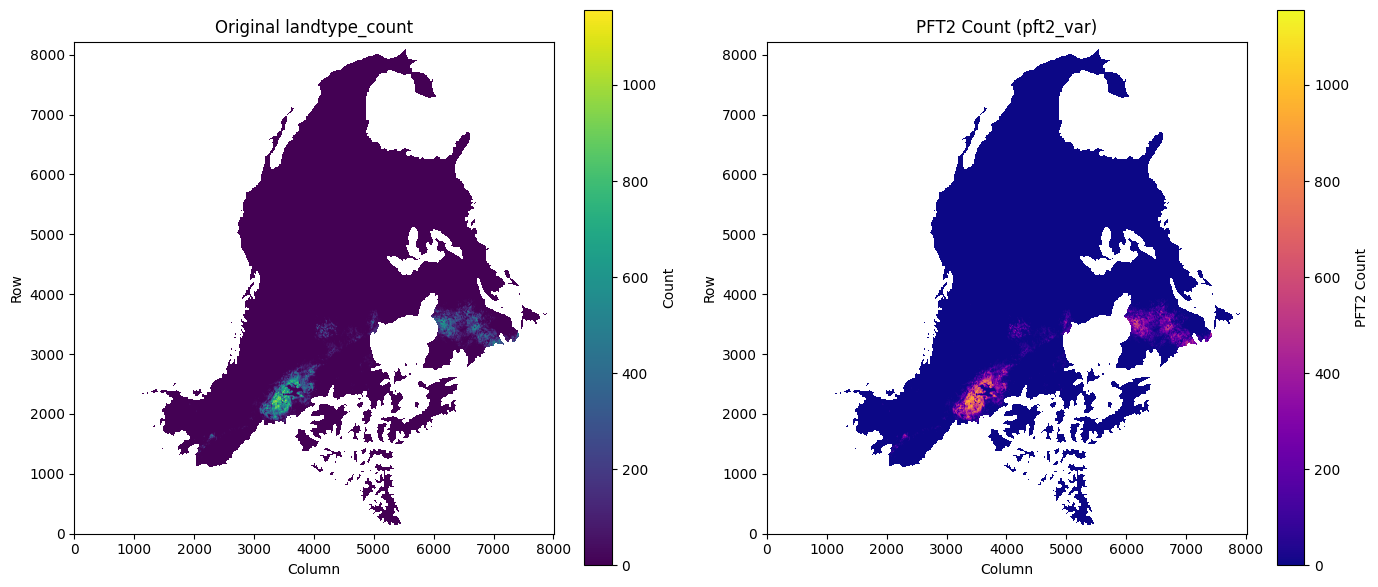

In [70]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt

# Load the count and pft2 from the NetCDF file
with Dataset('pft2_llandtype2_nalcms_Taiga_needleleaf.nc') as nc:
    pft2 = nc.variables['pft2_count'][:]

# If you want to plot the original count variable as well, load it from the source file
with Dataset('../landtypes_count/landtype2_nalcms_Taiga_needleleaf_in_daymet.nc') as nc:
    count = nc.variables['landtype_count'][:]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(count, origin='lower', cmap='viridis')
plt.title('Original landtype_count')
plt.colorbar(label='Count')
plt.xlabel('Column')
plt.ylabel('Row')

plt.subplot(1, 2, 2)
plt.imshow(pft2, origin='lower', cmap='plasma')
plt.title('PFT2 Count (pft2_var)')
plt.colorbar(label='PFT2 Count')
plt.xlabel('Column')
plt.ylabel('Row')

plt.tight_layout()
plt.show()

In [89]:
#create pft4 from landtype3_nalcms_Tropical_evergreen_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype3_nalcms_Tropical_evergreen_in_daymet.nc'
elm_pft = 'pft4'  # Define the PFT name for this landtype
# Load the large mask (landtype3_nalcms_Tropical_evergreen_in_daymet.nc)
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the pft4 as a new NetCDF file
with Dataset(f'{elmpft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_3930/1298720550.py:19: RuntimeWarning: invalid value encountered in cast
  pft_var[:, :] = count


Saved PFT counts as pft4_landtype3_nalcms_Tropical_evergreen_in_daymet.nc


In [87]:
#create pft6 from landtype4_nalcms_Tropical_deciduous_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype4_nalcms_Tropical_deciduous_in_daymet.nc'
elm_pft = 'pft6'  # Define the PFT name for this landtype
# Load the large mask (landtype3_nalcms_Tropical_evergreen_in_daymet.nc)
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the pft4 as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_3930/3496641015.py:19: RuntimeWarning: invalid value encountered in cast
  pft_var[:, :] = count


Saved PFT counts as pft6_landtype4_nalcms_Tropical_deciduous_in_daymet.nc


In [114]:
#create pft7-8 from the aligned_temp_to_large_nalcms_mask.nc and landtype5_nalcms_Temperate_deciduous_in_daymet.nc 
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype5_nalcms_Temperate_deciduous_in_daymet.nc'
elm_pft = 'pft7-8'  # Define the PFT name for this landtype
# Load the large mask (landtype3_nalcms_Tropical_evergreen_in_daymet.nc)
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# Load the averaged temperature data     
with Dataset('aligned_temp_to_large_nalcms_mask.nc') as nc:
    avg_temp = nc.variables['AvgTemp'][:]

upper_bound = 5  # Define the upper bound for PFT7-8
lower_bound = -15 # Define the lower bound for PFT7-8

# Only consider cells with count >= 0 and valid temperature
valid = (~np.isnan(avg_temp)) & (count >= 0)

# Initialize output arrays
pft7 = np.zeros_like(count, dtype=int)
pft8 = np.zeros_like(count, dtype=int)

# Masks for each region
mask1 = valid & (avg_temp <= lower_bound)
mask2 = valid & (avg_temp > upper_bound)
mask_between = valid & (avg_temp > lower_bound) & (avg_temp <= upper_bound)

# Assign values
pft8[mask1] = count[mask1]
pft7[mask2] = count[mask2]
# For the in-between region, use vectorized calculation
frac = (avg_temp[mask_between] - lower_bound) / (upper_bound - lower_bound)
pft7[mask_between] = (count[mask_between] * frac).astype(int)
pft8[mask_between] = count[mask_between] - pft7[mask_between]

# save the pft7-8 as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft7.shape[0])
    dst.createDimension('x', pft7.shape[1])
    pft7_var = dst.createVariable('pft7_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft7_var[:, :] = pft7
    pft7_var.long_name = "PFT 7 count based on AvgTemp"
    pft7_var.units = "count"
    pft8_var = dst.createVariable('pft8_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft8_var[:, :] = pft8
    pft8_var.long_name = "PFT 8 count based on AvgTemp"
    pft8_var.units = "count"
    avg_temp_var = dst.createVariable('AvgTemp', 'f4', ('y', 'x'), fill_value=np.nan, zlib=True, complevel=5)
    avg_temp_var[:, :] = avg_temp
    avg_temp_var.long_name = "Average temperature of coldest month (aligned to large mask)"
    avg_temp_var.units = "C"    
    # add a global attribute for the temperature bounds
    dst.setncattr('temperature_bounds', f'PFT 8: <= {lower_bound} C, PFT 7: > {upper_bound} C')
    # add a global attribute for the original landtype file
    dst.setncattr(f'original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

Saved PFT counts as pft7-8_landtype5_nalcms_Temperate_deciduous_in_daymet.nc


In [115]:
#create pft7-8 from the aligned_temp_to_large_nalcms_mask.nc and landtype6_nalcms_Mixed_forrest_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype6_nalcms_Mixed_forrest_in_daymet.nc'
elm_pft = 'pft7-8'  # Define the PFT name for this landtype
# Load the large mask (landtype3_nalcms_Tropical_evergreen_in_daymet.nc)
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# Load the averaged temperature data     
with Dataset('aligned_temp_to_large_nalcms_mask.nc') as nc:
    avg_temp = nc.variables['AvgTemp'][:]

upper_bound = 5  # Define the upper bound for PFT7-8
lower_bound = -19 # Define the lower bound for PFT7-8

# Only consider cells with count >= 0 and valid temperature
valid = (~np.isnan(avg_temp)) & (count >= 0)

# Initialize output arrays
pft7 = np.zeros_like(count, dtype=int)
pft8 = np.zeros_like(count, dtype=int)

# Masks for each region
mask1 = valid & (avg_temp <= lower_bound)
mask2 = valid & (avg_temp > upper_bound)
mask_between = valid & (avg_temp > lower_bound) & (avg_temp <= upper_bound)

# Assign values
pft8[mask1] = count[mask1]
pft7[mask2] = count[mask2]
# For the in-between region, use vectorized calculation
frac = (avg_temp[mask_between] - lower_bound) / (upper_bound - lower_bound)
pft7[mask_between] = (count[mask_between] * frac).astype(int)
pft8[mask_between] = count[mask_between] - pft7[mask_between]

# save the pft7-8 as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft7.shape[0])
    dst.createDimension('x', pft7.shape[1])
    pft7_var = dst.createVariable('pft7_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft7_var[:, :] = pft7
    pft7_var.long_name = "PFT 7 count based on AvgTemp"
    pft7_var.units = "count"
    pft8_var = dst.createVariable('pft8_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft8_var[:, :] = pft8
    pft8_var.long_name = "PFT 8 count based on AvgTemp"
    pft8_var.units = "count"
    avg_temp_var = dst.createVariable('AvgTemp', 'f4', ('y', 'x'), fill_value=np.nan, zlib=True, complevel=5)
    avg_temp_var[:, :] = avg_temp
    avg_temp_var.long_name = "Average temperature of coldest month (aligned to large mask)"
    avg_temp_var.units = "C"    
    # add a global attribute for the temperature bounds
    dst.setncattr('temperature_bounds', f'PFT 8: <= {lower_bound} C, PFT 7: > {upper_bound} C')
    # add a global attribute for the original landtype file
    dst.setncattr(f'original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

Saved PFT counts as pft7-8_landtype6_nalcms_Mixed_forrest_in_daymet.nc


In [106]:
#create pft9 from landtype7_nalcms_Tropical_shrub_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype7_nalcms_Tropical_shrub_in_daymet.nc'
elm_pft = 'pft9'  # Define the PFT name for this landtype
# Load the large mask (landtype9_nalcms_Tropical_grass_in_daymet.nc)
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the pft4 as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_3930/2386826546.py:19: RuntimeWarning: invalid value encountered in cast
  pft_var[:, :] = count


Saved PFT counts as pft9_landtype7_nalcms_Tropical_shrub_in_daymet.nc


In [91]:
#create pft10-11 from the aligned_temp_to_large_nalcms_mask.nc and landtype8_nalcms_Temperate_shrub_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype8_nalcms_Temperate_shrub_in_daymet.nc'
elm_pft = 'pft10-11'  # Define the PFT name for this landtype
# Load the large mask (landtype8_nalcms_Temperate_shrub_in_daymet.nc)
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# Load the averaged temperature data     
with Dataset('aligned_temp_to_large_nalcms_mask.nc') as nc:
    avg_temp = nc.variables['AvgTemp'][:]

upper_bound = 5  # Define the upper bound for PFT10-11
lower_bound = -15 # Define the lower bound for PFT10-11

# Only consider cells with count >= 0 and valid temperature
valid = (~np.isnan(avg_temp)) & (count >= 0)

# Initialize output arrays
pft10 = np.zeros_like(count, dtype=int)
pft11 = np.zeros_like(count, dtype=int)

# Masks for each region
mask1 = valid & (avg_temp <= lower_bound)
mask2 = valid & (avg_temp > upper_bound)
mask_between = valid & (avg_temp > lower_bound) & (avg_temp <= upper_bound)

# Assign values
pft11[mask1] = count[mask1]
pft10[mask2] = count[mask2]
# For the in-between region, use vectorized calculation
frac = (avg_temp[mask_between] - lower_bound) / (upper_bound - lower_bound)
pft10[mask_between] = (count[mask_between] * frac).astype(int)
pft11[mask_between] = count[mask_between] - pft7[mask_between]

# save the pft7-8 as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft10.shape[0])
    dst.createDimension('x', pft10.shape[1])
    pft10_var = dst.createVariable('pft10_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft10_var[:, :] = pft10
    pft10_var.long_name = "PFT 10 count based on AvgTemp"
    pft10_var.units = "count"
    pft11_var = dst.createVariable('pft8_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft11_var[:, :] = pft11
    pft11_var.long_name = "PFT 11 count based on AvgTemp"
    pft11_var.units = "count"
    avg_temp_var = dst.createVariable('AvgTemp', 'f4', ('y', 'x'), fill_value=np.nan, zlib=True, complevel=5)
    avg_temp_var[:, :] = avg_temp
    avg_temp_var.long_name = "Average temperature of coldest month (aligned to large mask)"
    avg_temp_var.units = "C"    
    # add a global attribute for the temperature bounds
    dst.setncattr('temperature_bounds', f'PFT 11: <= {lower_bound} C, PFT 10: > {upper_bound} C')
    # add a global attribute for the original landtype file
    dst.setncattr(f'original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/Users/7xw/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:489: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)


Saved PFT counts as pft10-11_landtype8_nalcms_Temperate_shrub_in_daymet.nc


In [105]:
#create pft14 from landtype9_nalcms_Tropical_grass_in_daymet.nc 
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype9_nalcms_Tropical_grass_in_daymet.nc'
elm_pft = 'pft14'  # Define the PFT name for this landtype
# Load the large mask (landtype9_nalcms_Tropical_grass_in_daymet.nc)
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the pft4 as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_3930/175592216.py:19: RuntimeWarning: invalid value encountered in cast
  pft_var[:, :] = count


Saved PFT counts as pft14_landtype9_nalcms_Tropical_grass_in_daymet.nc


In [94]:
#create pft12-13 from the aligned_temp_to_large_nalcms_mask.nc and landtype10_nalcms_Temperate_grass_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype10_nalcms_Temperate_grass_in_daymet.nc'
elm_pft = 'pft12-13'  # Define the PFT name for this landtype
# Load the large mask (landtype10_nalcms_Temperate_grass_in_daymet.nc)
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# Load the averaged temperature data     
with Dataset('aligned_temp_to_large_nalcms_mask.nc') as nc:
    avg_temp = nc.variables['AvgTemp'][:]

upper_bound = -19  # Define the upper bound for PFT12-13
lower_bound = -19  # Define the lower bound for PFT12-13

# Only consider cells with count >= 0 and valid temperature
valid = (~np.isnan(avg_temp)) & (count >= 0)

# Initialize output arrays
pft12 = np.zeros_like(count, dtype=int)
pft13 = np.zeros_like(count, dtype=int)

# Masks for each region
mask1 = valid & (avg_temp <= lower_bound)
mask2 = valid & (avg_temp > upper_bound)
#mask_between = valid & (avg_temp > lower_bound) & (avg_temp <= upper_bound)

# Assign values
pft12[mask1] = count[mask1]
pft13[mask2] = count[mask2]


# save the pft12-13 as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft12.shape[0])
    dst.createDimension('x', pft12.shape[1])
    pft12_var = dst.createVariable('pft10_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft12_var[:, :] = pft12
    pft12_var.long_name = "PFT 12 count based on AvgTemp"
    pft12_var.units = "count"
    pft13_var = dst.createVariable('pft13_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft13_var[:, :] = pft13
    pft13_var.long_name = "PFT 13 count based on AvgTemp"
    pft13_var.units = "count"
    avg_temp_var = dst.createVariable('AvgTemp', 'f4', ('y', 'x'), fill_value=np.nan, zlib=True, complevel=5)
    avg_temp_var[:, :] = avg_temp
    avg_temp_var.long_name = "Average temperature of coldest month (aligned to large mask)"
    avg_temp_var.units = "C"    
    # add a global attribute for the temperature bounds
    dst.setncattr('temperature_bounds', f'PFT 12: <= {lower_bound} C, PFT 13: > {upper_bound} C')
    # add a global attribute for the original landtype file
    dst.setncattr(f'original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/Users/7xw/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:489: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)


Saved PFT counts as pft12-13_landtype10_nalcms_Temperate_grass_in_daymet.nc


In [104]:
#create pft11 from landtype11_nalcms_Polar_shrub_moss_in_daymet.nc 
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype11_nalcms_Polar_shrub_moss_in_daymet.nc'
elm_pft = 'pft11'  # Define the PFT name for this landtype
# Load the large mask (landtype11_nalcms_Polar_shrub_moss_in_daymet.nc)
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the pft4 as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_3930/3128666245.py:19: RuntimeWarning: invalid value encountered in cast
  pft_var[:, :] = count


Saved PFT counts as pft11_landtype11_nalcms_Polar_shrub_moss_in_daymet.nc


In [103]:
#create pft12 from landtype12_nalcms_Polar_grass_moss_in_daymet.nc 
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype12_nalcms_Polar_grass_moss_in_daymet.nc'
elm_pft = 'pft12'  # Define the PFT name for this landtype
# Load the large mask (landtype12_nalcms_Polar_grass_moss_in_daymet.nc)
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the pft4 as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_3930/3045255127.py:19: RuntimeWarning: invalid value encountered in cast
  pft_var[:, :] = count


Saved PFT counts as pft12_landtype12_nalcms_Polar_grass_moss_in_daymet.nc


In [107]:
#create pft12 from landtype13_nalcms_Polar_barren_moss_in_daymet.nc 
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype13_nalcms_Polar_barren_moss_in_daymet.nc'
elm_pft = 'pft12'  # Define the PFT name for this landtype
# Load the large mask 
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the pft as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_3930/2436748960.py:19: RuntimeWarning: invalid value encountered in cast
  pft_var[:, :] = count


Saved PFT counts as pft12_landtype13_nalcms_Polar_barren_moss_in_daymet.nc


In [102]:
#create pft13 from landtype14_nalcms_Wetland_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype14_nalcms_Wetland_in_daymet.nc'
elm_pft = 'pft13'  # Define the PFT name for this landtype
# Load the large mask 
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the elm_pft as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_3930/2675274509.py:19: RuntimeWarning: invalid value encountered in cast
  pft_var[:, :] = count


Saved PFT counts as pft13_landtype14_nalcms_Wetland_in_daymet.nc


In [101]:
#create pft15 from landtype15_nalcms_Cropland_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype15_nalcms_Cropland_in_daymet.nc'
elm_pft = 'pft15'  # Define the PFT name for this landtype
# Load the large mask 
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the elm_pft as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_3930/1156677079.py:19: RuntimeWarning: invalid value encountered in cast
  pft_var[:, :] = count


Saved PFT counts as pft15_landtype15_nalcms_Cropland_in_daymet.nc


In [109]:
#create pft0 from landtype16_nalcms_Barren_land_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype16_nalcms_Barren_land_in_daymet.nc'
elm_pft = 'pft0'  # Define the PFT name for this landtype
# Load the large mask 
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the elm_pft as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_3930/3747129637.py:19: RuntimeWarning: invalid value encountered in cast
  pft_var[:, :] = count


Saved PFT counts as pft0_landtype16_nalcms_Barren_land_in_daymet.nc


In [111]:
#create urban from landtype17_nalcms_Urban_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype17_nalcms_Urban_in_daymet.nc'
elm_pft = 'urban'  # Define the PFT name for this landtype
# Load the large mask 
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the elm_pft as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_3930/3176323712.py:19: RuntimeWarning: invalid value encountered in cast
  pft_var[:, :] = count


Saved PFT counts as urban_landtype17_nalcms_Urban_in_daymet.nc


In [112]:
#create lake from landtype18_nalcms_Water_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype18_nalcms_Water_in_daymet.nc'
elm_pft = 'lake'  # Define the PFT name for this landtype
# Load the large mask 
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the elm_pft as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_3930/4187041667.py:19: RuntimeWarning: invalid value encountered in cast
  pft_var[:, :] = count


Saved PFT counts as lake_landtype18_nalcms_Water_in_daymet.nc


In [113]:
#create pft0 from landtype19_nalcms_Snow_Ice_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype19_nalcms_Snow_Ice_in_daymet.nc'
elm_pft = 'pft0'  # Define the PFT name for this landtype
# Load the large mask 
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the elm_pft as a new NetCDF file
with Dataset(f'{elm_pft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_3930/4205100908.py:19: RuntimeWarning: invalid value encountered in cast
  pft_var[:, :] = count


Saved PFT counts as pft0_landtype19_nalcms_Snow_Ice_in_daymet.nc
